In [1]:
import pandas as pd
import numpy as np
import os
import sys
from sklearn.linear_model import LinearRegression
chemin_dev = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if chemin_dev not in sys.path:
    sys.path.append(chemin_dev)
from options_pricing.scripts import data_processing as dp
from options_pricing.scripts import black_scholes as bs
from options_pricing.scripts import linear_reg as lr
from matplotlib import pyplot as plt
from scipy.stats import norm, shapiro
import statsmodels.api as sm
from sklearn.feature_selection import f_regression

In [2]:
df_options = pd.read_csv('../../data/options/options_processed.csv')
df_options_c = df_options.loc[df_options['call_put'] == 'Call']

In [3]:
params = {
    'test_size' : 0.1, # If we choose 0, we test on all the rest of the data (not used for training or validation
    'n_rows' : 1000,
    'standardize' : False,
    'fit_intercept' : True, # Default is True but our data are already centered 'If set to False, no intercept will be used in calculations (i.e. data is expected to be centered).'
    'features': ['strike','vol', 'delta', 'gamma', 'theta', 'vega', 'rho', 'stock_price','time_to_maturity', 'interest_rate'],
}

In [4]:
X_train, X_test, y_train, y_test, scaler = dp.create_train_test_set_by_act_symbol(
    df_options_c,
    params['test_size'],
    params['n_rows'], 
    params['features'],
    params['standardize']
    )
# The explicative variables are scaled and standardized

In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1188, 10), (132, 10), (1188,), (132,))

In [6]:
lin_reg_model = LinearRegression(fit_intercept=params['fit_intercept'])

In [7]:
lin_reg_model.fit(X_train, y_train)

LinearRegression()

In [8]:
y_pred = lin_reg_model.predict(X_test)
bs.compute_metrics(y_test, y_pred)

MAPE:  6.110021363692871
MAE:  10.753129777872973
MSE:  231.0792724336126
R2:  0.9675825515423605
-----------------------------------




(6.110021363692871, 10.753129777872973, 231.0792724336126, 0.9675825515423605)

The first observation, regarding the parameters standardize & fit_intercept is 

| standardize      | fit_intercept      | MSE      |
| -------------- | -------------- | -------------- |
| False | True |  8.3346 |
| True | True | 8.3346 |
| False | False | 8.3571 |
| True | False | 38.1083 |


## Coefficients 

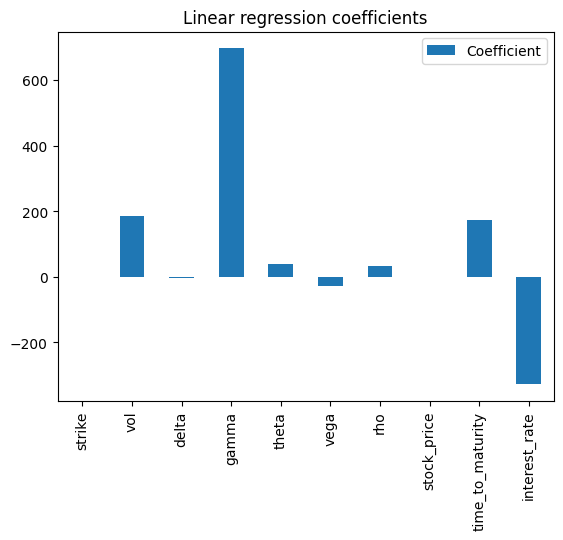

In [9]:
coefficients = pd.DataFrame(lin_reg_model.coef_, X_train.columns, columns=['Coefficient'])
coefficients.plot(kind='bar')
plt.title('Linear regression coefficients')
plt.show()

Case when data are not normalize : 
We can interpret this graph as follow. The bars represent the increase or decrease of the option price when the variables increase. 

Effect size problems : strike (tens €) vs volatility (0.4)

## Feature selection

$
\left\{\begin{matrix}
H_0 : b_j  = 0 \quad i.e :  \text{The variables have no correlation with the option price}\\ 
H_1 : b_j \neq 0
\end{matrix}\right.
$ 

We use the statistic
$ F = \frac{MSR}{MSE}$ With 

$MSR : \text{Mean regression sum of squares : average square between the predicted values and the mean of the dependant variable }$

$MSE : \text{moyenne dispersion résiduel}$

In [10]:
F_values, p_values = f_regression(X_train, y_train)

# Créer un DataFrame pour afficher les résultats
anova_results = pd.DataFrame({
    'Feature': [feature for feature in X_train.columns],
    'F_value': F_values,
    'p_value': p_values
})

print(anova_results)

            Feature      F_value        p_value
0            strike   209.274642   8.389725e-44
1               vol    12.903145   3.414605e-04
2             delta   783.362992  9.151101e-133
3             gamma   288.816251   3.872694e-58
4             theta    59.803897   2.227171e-14
5              vega    65.925223   1.164020e-15
6               rho  1762.365212  8.847606e-237
7       stock_price   403.929380   1.501206e-77
8  time_to_maturity    10.144905   1.484700e-03
9     interest_rate     0.108720   7.416642e-01


In [11]:
r2 = lin_reg_model.score(X_test, y_test)
print(r2)

0.9675825515423605


$R^2$ indicates the proportion of variation in the y-variable that is due to variation in the x-variables. 

## Analysis of variance

In [12]:
# Convertir les données en DataFrame pour l'utilisation avec statsmodels
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
df_train = pd.DataFrame(X_train)
df_train['y'] = y_train

In [13]:
formula = 'y ~ ' + ' + '.join(df_train.columns[:-1])
# 'y ~ strike + vol + delta + gamma + theta + vega + rho + stock_price + time_to_maturity + interest_rate'
model_sm = ols(formula, data=df_train).fit()


anova_results = anova_lm(model_sm)
print(anova_results)

                      df        sum_sq       mean_sq             F  \
strike               1.0  9.921859e+05  9.921859e+05   5648.141478   
vol                  1.0  2.801216e+05  2.801216e+05   1594.627246   
delta                1.0  2.730517e+06  2.730517e+06  15543.808842   
gamma                1.0  9.439004e+04  9.439004e+04    537.327007   
theta                1.0  2.530245e+05  2.530245e+05   1440.373609   
vega                 1.0  3.556494e+04  3.556494e+04    202.457857   
rho                  1.0  1.442725e+06  1.442725e+06   8212.891382   
stock_price          1.0  5.544316e+05  5.544316e+05   3156.170498   
time_to_maturity     1.0  2.494521e+04  2.494521e+04    142.003733   
interest_rate        1.0  4.309774e+02  4.309774e+02      2.453393   
Residual          1177.0  2.067588e+05  1.756659e+02           NaN   

                         PR(>F)  
strike             0.000000e+00  
vol               3.879106e-221  
delta              0.000000e+00  
gamma              3.20

We constat that the f_regression is not sensitive to normalization but anova is. 

Looking at the document, we can constat that f_regression is based on the the Pearson correlation : 
$$\text{corr}(X[:, i], y) = \frac{E[(X[:, i] - \text{mean}(X[:, i])) \cdot (y - \text{mean}(y))]}{\text{std}(X[:, i]) \cdot \text{std}(y)}$$
That already includes normalization. 

It is not the case for ANOVA, during the computation of $MSR$ and $MSE$

## Residuals analysis

In [14]:
y_pred_train = lin_reg_model.predict(X_train)

Computations of standardized residuals
- We compute the residual matrice / ortohonal projection matrice $R = I_n-X(X^TX)^{-1}X^T$
remark : $R = I_n - H$ where $H$ is the hat matrice such that $\hat{Y} = HY$
- We compute the residuals : $ \hat{\varepsilon }_i = Y_i - \hat{Y_i}$
- Compute variance : $\hat{\sigma}^2 = \frac{1}{n-p}\sum_{i=1}^n\hat{\epsilon_i}^2$ 
- $\tilde{\varepsilon_i} = \frac{\hat{\varepsilon }_i}{\sqrt{\hat{\sigma}^2\times r_{ii}}}$


In [15]:
p = len(params['features'])
standardized_residuals = lr.compute_standardized_residuals_fast(X_train, y_train, y_pred_train, p)

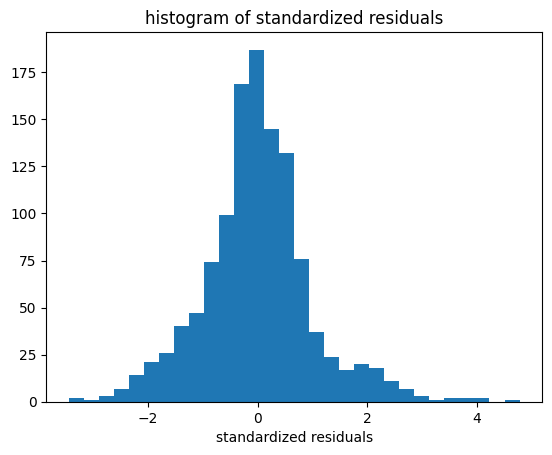

In [16]:
plt.hist(standardized_residuals, bins=30)
plt.xlabel('standardized residuals')
plt.title('histogram of standardized residuals')
plt.show()

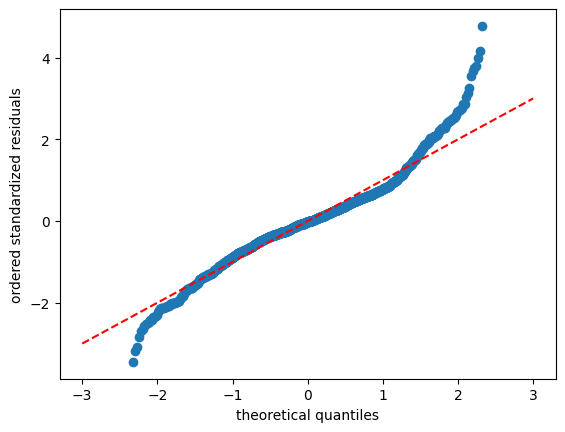

In [17]:
# We use the quantile function ppf of normal distribution
theoretical_quantiles = norm.ppf(np.linspace(0.01, 0.99, len(standardized_residuals)))
residuals_sorted = np.sort(standardized_residuals)
plt.scatter(theoretical_quantiles, residuals_sorted)
plt.xlabel('theoretical quantiles')
plt.ylabel('ordered standardized residuals')
plt.plot([-3, 3], [-3, 3], color='red', linestyle='--')


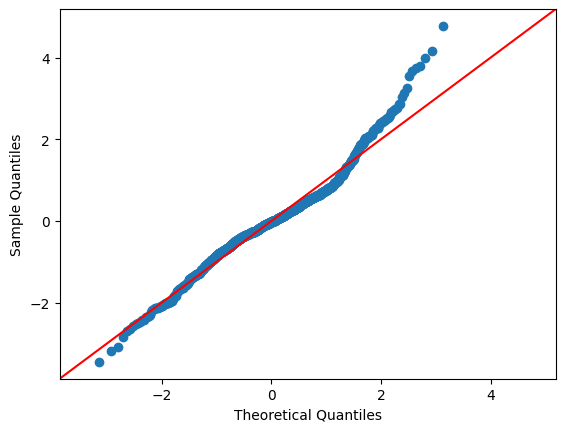

In [18]:
sm.qqplot(standardized_residuals, line ='45')
plt.show()

In [19]:
_, p_value  = shapiro(standardized_residuals)
print(p_value)

7.254205503813443e-15


Text(0, 0.5, 'standardized residuals')

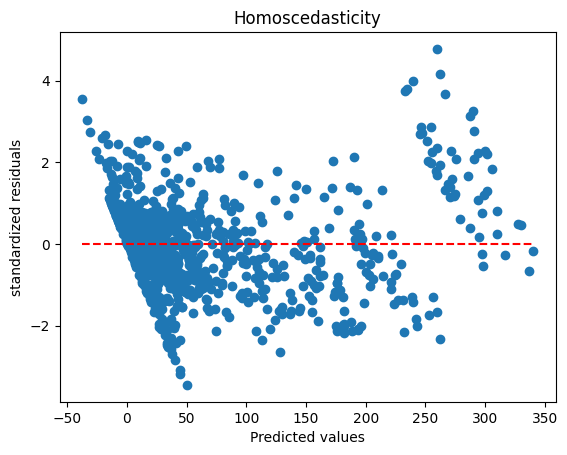

In [20]:
plt.scatter(y_pred_train, standardized_residuals)
plt.plot([min(y_pred_train), max(y_pred_train)], [0, 0], color='red', linestyle='--')
plt.title('Homoscedasticity')
plt.xlabel('Predicted values')
plt.ylabel('standardized residuals')